# Лабораторную выполнили Жилин и Зимин Андреи

На паре сказали что Жилин Андрей 10(оказалось 9, но уже сделал для 10) что же поделать

(Линейный тренд и Ряд фурье)

# 1 задание

Загрузите данные и проверьте их на наличие пропусков и аномалий.


Постройте график временного ряда и визуально оцените динамику числа
пассажиров.

In [488]:
import pandas as pd
import numpy as np
import datetime
import time
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
df = pd.read_csv('data/airline-passengers.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


## Задание 1.1
Загрузите данные и проверьте их на наличие пропусков и аномалий.

In [489]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


## Комментарии

Ну видим 144 записей, 0 пропусков, аномалии оценим по графику

## Задание 1.2
Построить график и я перенес задание по аномалиям сюда

<Axes: xlabel='Номер месяца', ylabel='Число пассажиров'>

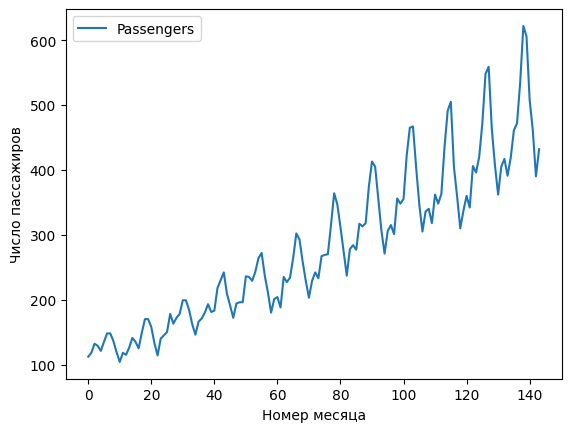

In [490]:
df[['Passengers']].plot(xlabel='Номер месяца', ylabel='Число пассажиров')

Видно, что выбросов нет, а также заметна тенденция роста числа пассажиров

# Подготовка перед выполнением второго задания


## Реализация градиентного спуска

In [491]:
class GradientDescent:
    def __init__(self, train_x, train_y, h = 0.00005, eps=0.1, start_weights=None, logging=False, min_iterations=0, strategy="package", batch_size=1):

        #часть за данные ааа
        self.X = train_x #тренировочная выборка
        self.y = train_y #целевой признак
        self.strategy = strategy

        #метаданные
        self.width = len(train_x[0]) + 1 #ширина тренировочной выборки
        self.height = len(train_x) #высота тренировочной выборки
        
        #модель 
        self.batch_size = batch_size
        self.min_iterations = min_iterations
        self.h = h #шаг градиентного спуска h > 0
        self.eps = eps #точность градиентного спуска
        self.strategies = {'package': self.step_package, 'mini-batch': self.step_mini_batch, 'stochastic': self.step_mini_batch}
        if strategy == 'stochastic':
            self.batch_size = 1
        if start_weights is None: #задание стартовых весов
            self.w = np.full(self.width, 1)
        else:
            self.w = start_weights

        self.X = np.concatenate((np.ones(self.height).reshape(-1, 1), self.X), axis=1) #фиктивная единица
        self.q = self.calc_q() # инициализируем ошибку

        #логи
        self.logging = logging
        self.qs = np.array([]) #величина ошибки
        self.curr_timer = None
        self.timer = np.array([]) #массив для хранения время итераций
        self.iter_num = 0
        
        
    def start_timer(self):
        self.curr_timer = datetime.datetime.now()
    
    def stop_timer(self):
        self.timer = np.append(self.timer, np.array(datetime.datetime.now() - self.curr_timer))

    def get_time(self):
        return self.timer.sum()

    def get_times(self):
        return self.timer
    
    def step_package(self):
        self.start_timer()
        self.w = self.w - self.h * self.grad()

    
    def step_mini_batch(self):
        
        idx = np.random.randint(self.height, size=self.batch_size) # формируем индексы пакета
        self.w = self.w - self.h * self.grad(self.X[idx, :], self.y[idx, :]) #вычисляем градиент по пакету и меняем веса
        
    
    def grad(self, X = None, y = None): #вычисление градиента по пакету(подходит для mini-batch, package и stochastic)
        if X is None or y is None or np.size(X)==0 or np.size(y)==0:
            X = self.X
            y = self.y

        return (X.T.dot(X.dot(self.w) - y[:, 0]))*(2/self.height)

    def fit(self):
        
        q = 2*self.q

        if self.logging:
            print("Величина ошибки на каждом шаге")

        while abs(self.q - q) > self.eps or self.iter_num < self.min_iterations:
            self.start_timer()
            q = self.q #переприсваеваем значение ошибки 
            self.strategies[self.strategy]()
            self.qs = np.append(self.qs, q) #запоминаем значение ошибки
            self.q = self.calc_q() #вычисление значение ошибки после новых весов
            self.iter_num += 1
            self.stop_timer()

            if self.logging:
                print(f"Шаг {self.iter_num}: ошибка {round(self.q, int(np.log(1/self.eps)/np.log(10)))};") #логи        
        if self.logging:
            print(f"Время работы: {self.get_time().microseconds/1000:.02f} мс")
        return self.w


    def calc_q(self):
        return np.mean((np.dot(self.X, self.w) - self.y[:, 0]) ** 2)

    def predict(self, X):
        X =  np.concatenate((np.ones(len(X)).reshape(-1, 1), X), axis=1) #фиктивная единица
        return np.dot(X, self.w).reshape(-1, 1)

## Перевод в численное время (можно по айдишникам) не по месяцам, просто добавляем к индексам 1 и сами индексы теперь месяцы

In [492]:
df['Month'] = df['Month'].index + 1



In [493]:


x = df[['Month']].to_numpy()
y = df[['Passengers']].to_numpy()


## Реализация Временного ряда по нашему заданию

In [494]:

class TimeRow(GradientDescent): #наследуемся от градиентного спуска для линейной регрессии и построения тренда
    
    def __init__(self, t, y, m = 1, *args, **kwargs):
        
        self.scaler = MinMaxScaler() #скейлинг для удобства работы с градиентным спуском
        t = self.scaler.fit_transform(t) #тренировка и сразу запись
        super().__init__(t, y, *args, **kwargs) #инициализация родительского класса(градиентного спуска)
        self.fit() #запуск тренировки
        self.m = m # количество гармоник(во сколько раз уменьшаем
        self.ut = self.w[0] + self.w[1]*t # тренд
        self.fur = TimeRow.Fourier(self.m) #инициализация ряда фурье
        self.fur.build(t, y - self.ut) #его построение
    
    def predict(self, X): #переопределение класса предсказания
        X = self.scaler.transform(X) #переводим данные в нужный нам диапазон 
        ans = []
        for point in X:
            ans.append(self.fur.calc([point])[0] + ( self.w[0] + self.w[1] * point)) #предсказание
        return ans
        
    class Fourier: # инициализируем класс ряда фурье в классе временных рядов
        def __init__(self, m):
            self.a = []
            self.b = []
            self.length = None
            self.t = None
            self.m = m
    
        def build(self, t, ht):
            self.length = len(t)// 2 // self.m #задаем количество гармоник
            self.a = [0] * self.length # коэффициенты при косинусе
            self.b = [0] * self.length # коэффициенты при синусе
            self.w = 2 * np.pi # вес
            for i in range(0, self.length): #вычисляем за O(nm) ряд фурье
                for j in range(len(ht)):
                    self.a[i] += ht[j] * np.cos(t[j] * self.w * i) #гармоника cos
                    self.b[i] += ht[j] * np.sin(t[j] * self.w * i) #гармоника sin
            
            self.a[0] *= 2
            self.b[0] *= 2
            self.a[self.length-1] *= 2
            self.b[self.length-1] *= 2
            self.a = np.array(self.a) / self.length #переводим в numpy.array и делим все на T
            self.b = np.array(self.b) / self.length
    
        def calc(self, x):#вычисление для n точек значения ряда
            new_x = [0] * len(x)
            for i in range(len(x)):
                for j in range(self.length):
                    new_x[i] += np.cos(x[i] * self.w * j) * self.a[j]
                    new_x[i] += np.sin(x[i] * self.w * j) * self.b[j]
            return new_x


## Проверим работу ряда

In [ ]:
TR = TimeRow(df[['Month']].to_numpy(), df[['Passengers']].to_numpy(), m = 1, h=10**(-3), eps=0.0001, min_iterations=10000, logging=True)
#инициализируем временной ряд

In [496]:
yt_ = TR.predict(df[['Month']].to_numpy()) #вычисляем оценочное yt 

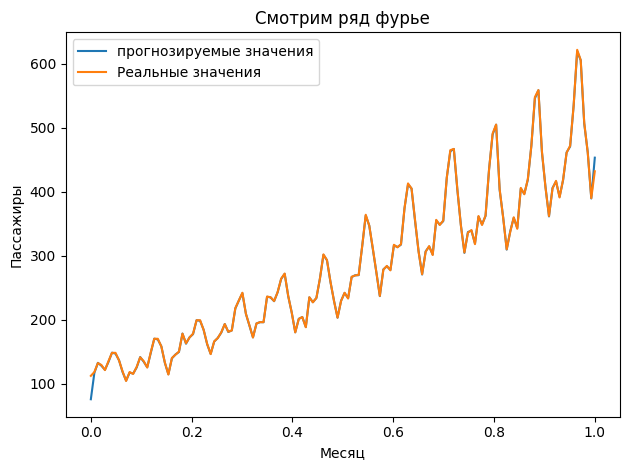

In [497]:

plt.plot(TR.scaler.transform(df[['Month']].to_numpy()), yt_, label='прогнозируемые значения') 
plt.plot(TR.scaler.transform(df[['Month']].to_numpy()), df['Passengers'], label='Реальные значения')
plt.xlabel('Месяц')
plt.ylabel('Пассажиры')
plt.legend(

)
plt.title('Смотрим ряд фурье')
plt.tight_layout()
plt.show()

Видно, что тренд и ряд фурье практически идеально интерполировали ряд, нам конечно это не нужно, но поговорим об этом уже во втором задании

# Задание 2
Теперь мы построим тренд и оценим ряд фурье, поскольку у нас уже готово всё

Построение тренда

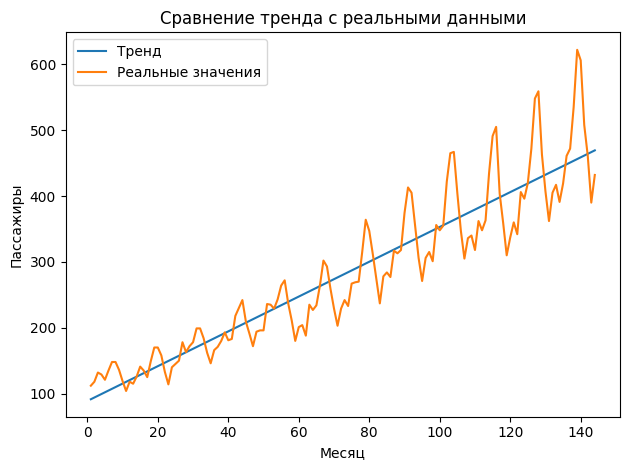

In [498]:
plt.plot(df['Month'], TR.ut, label='Тренд')
plt.plot(df['Month'], df['Passengers'], label='Реальные значения')
plt.xlabel('Месяц')
plt.ylabel('Пассажиры')

plt.title('Сравнение тренда с реальными данными')
plt.legend()
plt.tight_layout()
plt.show()

Тренд получился очень даже неплохим, на мой взгляд хорошо отражает реальную тенденцию

In [526]:
TR.fur.a[:10]#коэффициенты гармоник косинуса

array([[-0.60177669],
       [24.05008766],
       [-6.12346981],
       [16.18785147],
       [ 4.75174885],
       [11.08145392],
       [ 0.29099482],
       [-3.07073021],
       [ 2.04848716],
       [ 0.77271163]])

In [527]:
TR.fur.b[:10]#коэффициенты гармоник синуса

array([[  0.        ],
       [ -7.63881731],
       [  1.96692367],
       [  5.4738099 ],
       [ -0.66269927],
       [ -5.68343635],
       [ -2.74101977],
       [ -5.72189778],
       [ -1.92893379],
       [-10.55021947]])

Судя по выводу в синусе все равномерно влияют, однако в косинусе особенно сильно выделяется первая и третья компонента и еще одна компонента которая имеет -43, а в синусе особенно выделяются три компоненты

In [501]:
x_train = df[['Month']].to_numpy()[:len(df['Month']) - 11, : ] 
y_train = df[['Passengers']].to_numpy()[:len(df['Month']) - 11, :]
x_test = df[['Month']].to_numpy()[len(df['Month']) - 12:, : ]
y_test = df[['Passengers']].to_numpy()[len(df['Month']) - 12:, : ]
TR = TimeRow(x_train, y_train, m = 2, h=10**(-3), eps=0.0001, min_iterations=10000, logging=False)


Здесь подготовили данные к следующему заданию

# Задание 3 метрики

Сделайте точечный прогноз числа пассажиров на следующий 1961 год.

Проверьте качество подхода на основе метрик ошибки (например, RMSE, MAE),
сделав прогноз на 1960 год на основе предыдущих значений.

Представьте результаты в виде графика, где отображены реальные и
прогнозируемые значения. 


In [502]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

yt_ = TR.predict(x_train)  #вычисляем оценочное yt 

mse = mean_squared_error(yt_, y_train) #само за себя говорит

mae = mean_absolute_error(yt_, y_train)

r2 = r2_score(yt_, y_train)
print("На тестовой выборке")
print("MSE:", mse)
print("MAE: ", mae)
print("R2: ", r2)

yt_test = TR.predict(x_test)  

mse = mean_squared_error(yt_test, y_test)

mae = mean_absolute_error(yt_test, y_test)

r2 = r2_score(yt_test, y_test)

print("На обучающей выборке")
print("MSE:", mse)
print("MAE: ", mae)
print("R2: ", r2)

На тестовой выборке
MSE: 1754.53405708924
MAE:  33.06939357684365
R2:  0.8929965183437371
На обучающей выборке
MSE: 3259.520938389916
MAE:  43.25708967426878
R2:  -2.707865210985588


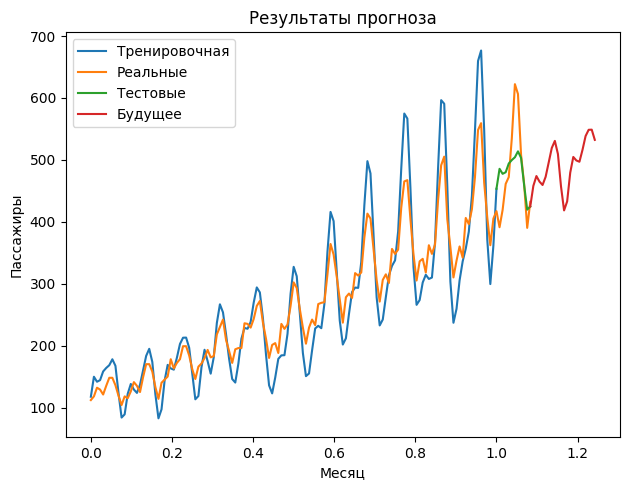

In [503]:


plt.plot(TR.scaler.transform(x_train), yt_, label='Тренировочная')
plt.plot(TR.scaler.transform(df[['Month']].to_numpy()), df[['Passengers']], label='Реальные')
plt.plot(TR.scaler.transform(x_test), TR.predict(x_test), label='Тестовые')
plt.plot(TR.scaler.transform(np.arange(144, 166).reshape(-1, 1)), TR.predict(np.arange(144, 166).reshape(-1, 1)), label='Будущее')
plt.xlabel('Месяц')
plt.ylabel('Пассажиры')
plt.legend()
plt.tight_layout()
plt.title('Результаты прогноза')
plt.show()

Ну как бы видно, что получается не очень, потому что модель пытается продолжить тенденцию с начала(характер графика в единице похож на характер графика в 0) грубо говоря ctrl + c, ctrl + v. 

Можно сделать вывод, что это скорее всего потому что, периодическая составляющая должна быть в произведении с трендом, а не в сумме. 

То есть yt = ut * ht + C

# Доп задание

Желающие могут сделать интервальный прогноз, для 95% и 98% уровня
значимости, отразив результаты в табличном и графическом виде (+2 балла).

Просто воспользуемся формулами из лекции

In [504]:
from scipy.stats import t
new_y = [0] * len(yt_)

for i in range(len(yt_)):
    new_y[i] = yt_[i][0]
new_y = np.array(new_y)

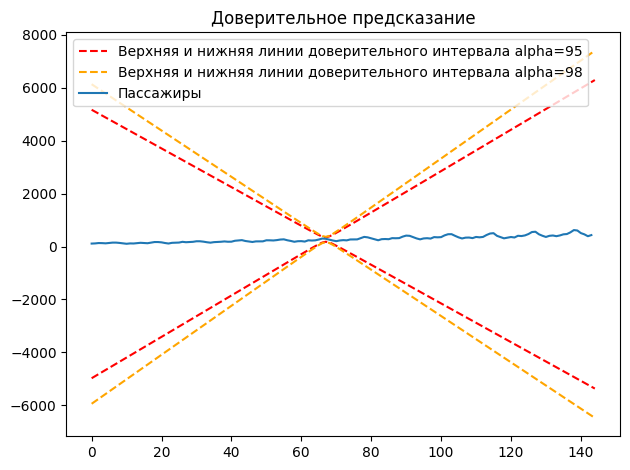

In [505]:
  


x_test_t = x_train.reshape(1, -1)[0]

t95 = t.ppf(1. - .05 / 2., 144)
t98 = t.ppf(1. - .02 / 2., 144)
T = len(new_y)
Sy = (sum((df['Passengers'][:T] - new_y)**2)/(T - 2))**(1/2)

time_ = TR.scaler.transform(np.arange(1, 146).reshape(-1, 1)).reshape(1, -1)[0]
t_ = time_.mean()

inter = []
for L in range(-133, 12):
    
    K_ = ((T+1)/T + 3*(T + 2*L - 1 )**2/sum((time_-t_)**2))**(1/2)
    Sp = Sy * K_
    
    inter.append(Sp)

plt.plot(np.array(inter) *t95 + TR.w[0] + TR.w[1]*time_, color='red', linestyle='--', label='Верхняя и нижняя линии доверительного интервала alpha=95')
plt.plot(np.array(inter)*(-1)*t95 + TR.w[0] + TR.w[1]*time_, color='red', linestyle='--')
plt.plot(np.array(inter) *t98 + TR.w[0] + TR.w[1]*time_, color='orange', linestyle='--', label='Верхняя и нижняя линии доверительного интервала alpha=98')
plt.plot(np.array(inter)*(-1)*t98 + TR.w[0] + TR.w[1]*time_, color='orange', linestyle='--')
plt.plot(df.Passengers, label='Пассажиры')
plt.legend(loc='best')
plt.title('Доверительное предсказание')

plt.tight_layout()
plt.show()


Получилось что-то странное, скорее всего значение ошибки слишком большое, потому доверительный интервал сильно растет в обе стороны

# 4 Проверка стационарности

Проверьте временной ряд на стационарность (любым из методов).

Если ряд нестационарен,
примените методы преобразования к
стационарному виду (например, дифференцирование).

## Проверка на стационарность
Безусловно мы математики, потому для проверки стационарности ряда используем предложенный на лекции Тест Дики Фуллера

In [506]:
from statsmodels.tsa.stattools import adfuller
res = adfuller(df['Passengers'])
print('Критерий Дики Фуллера: %f' % res[0])
print('p-value: %f' % res[1])
for k, v in res[4].items():
    print('\t%s: %.3f' % (k, v))

Критерий Дики Фуллера: 0.815369
p-value: 0.991880
	1%: -3.482
	5%: -2.884
	10%: -2.579


Как мы можем заметить, тест ADF показывает, что значение критерия намного превышает критические значения, а также значение p намного превышает 0,05 , мы не можем отклонить нулевую гипотезу о нестационарности этого ряда, следовательно, ряд нестационарен

## Дифференцирование

Теперь мы хотим сделать ряд стационарным, соответственно применим метод конечных разностей изученный на МОПС, к счастью в pandas есть метод у Series позволяющий нам сделать это 


In [528]:
diff_y = df['Passengers'].diff() #дифференцирование частичные разности, дальше они будут вшиты в модель ARIMA, поскольку так удобнее 
diff_y[:10]

0     NaN
1     6.0
2    14.0
3    -3.0
4    -8.0
5    14.0
6    13.0
7     0.0
8   -12.0
9   -17.0
Name: Passengers, dtype: float64

Естественно первое значение NaN, поскольку для него не нашлось предыдущего значения. Его уберем. На всякий случай убедимся в стационарности данного ряда

In [529]:
diff_y = diff_y.dropna()
diff_y[:10]

1      6.0
2     14.0
3     -3.0
4     -8.0
5     14.0
6     13.0
7      0.0
8    -12.0
9    -17.0
10   -15.0
Name: Passengers, dtype: float64

In [509]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
res = adfuller(diff_y)
print('Критерий Дики Фуллера: %f' % res[0])
print('p-value: %f' % res[1])
for k, v in res[4].items():
    print('\t%s: %.3f' % (k, v))

Критерий Дики Фуллера: -2.829267
p-value: 0.054213
	1%: -3.482
	5%: -2.884
	10%: -2.579


Заметно, что при определенном уровне значимости, а именно 0.1 мы можем отвергнуть нулевую гипотезу, соответственно ряд стационарен  

# Задание 5

Постройте и исследуйте автокорреляционную функцию (ACF), чтобы
определить подходящие параметры для модели ARIMA (SARIMA).

Сделайте прогноз на 1961 год и тестирование модели на 1960 год.

Обсудите полученные результаты и предложите возможные причины
отклонений между реальными данными и прогнозами.
Предложите рекомендации по улучшению точности прогнозов.

## Автокорреляционная функция

Постройте и исследуйте автокорреляционную функцию (ACF), чтобы
определить подходящие параметры для модели ARIMA (SARIMA).

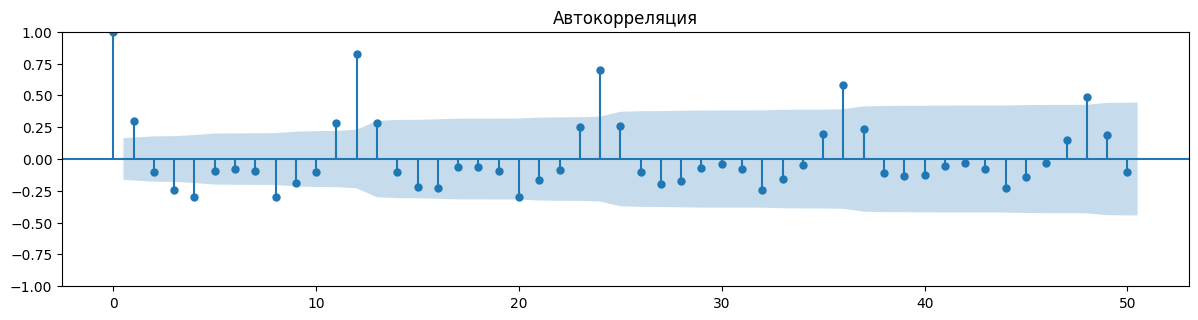

In [510]:
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(diff_y, lags=50, ax=plt.gca())
plt.title('Автокорреляция')


plt.tight_layout()
plt.show()

Видно, что закономерность автокорреляции примерно для каждого 15, для уверенности можно взять p = 15

## ARIMA

### реализация AR

In [511]:
class AR(GradientDescent):
    
    def __init__(self, x, p, d=1, *args, **kwargs):
        
        
        x_train = np.zeros(shape=(len(x) - p, p)) #инициализация обучающей выборки
        for i in range(p + 1, len(x)):
            x_train[i - p - 1] = x[i - p - 1:i - 1].reshape(-1, p) #формирование по предыдущим значением ряда 
        
        self.x_train = x_train  #по-хорошему надо сделать так
        
        super().__init__(x_train, x[p:], *args, **kwargs) #инициализируем родительский класс(градиентный спуск)
        self.p = p
        self.d = d
        self.fit() #запускаем обучение
        

## Проверяем работоспособность

In [530]:
ar = AR(pd.DataFrame(diff_y).to_numpy(), 3)
ar.w#веса похоже на правду судя по автокорреляции

array([ 0.99808935, -0.10719608, -0.18914126,  0.38907941])

## График для реализации AR

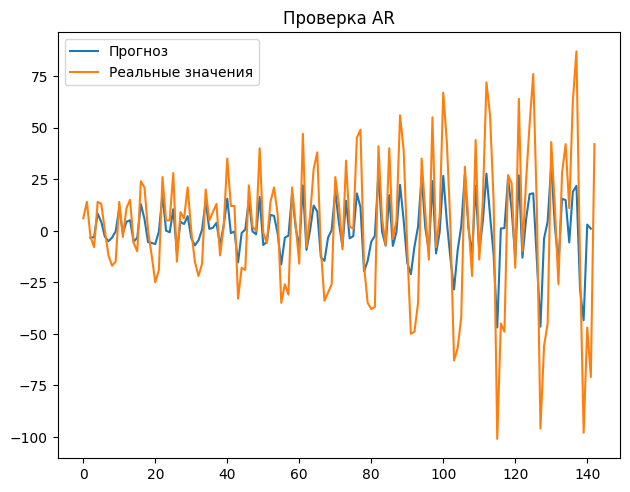

In [513]:
plt.plot(np.arange(ar.p - 1, ar.height + ar.p - 1), ar.predict(ar.x_train), label='Прогноз')
plt.plot(np.arange(len(diff_y)), diff_y, label='Реальные значения')
plt.legend(loc='best')
plt.tight_layout()
plt.legend()

plt.title('Проверка AR')
plt.show()

Видно, что модель прогнозирует не такие скачки как в реальных данных, а чуть меньше. 

Скорее всего это связано с тем что, слабая автокорреляция, несмотря на это, все равно закономерность модель видит

### Реализация MA

Реализуем подход MA его проверять не будем, потому что он сделан для предсказывания ошибки, а не целевой функции, не хочется его адаптировать для другого, просто запустим в общем

In [514]:
class MA(GradientDescent):
    
    def __init__(self, x, q , *args, **kwargs):
        self.mean = x.mean()
        print(x.mean())
        x = x - self.mean #вычитаем среднее
        x_train = np.zeros(shape=(len(x) - q, q)) #тренировочная выборка
        for i in range(q + 1, len(x)):
            x_train[i - q] = x[i - q - 1:i - 1].reshape(-1, q) #формируем обучающую выборку
        self.x_train = x_train
        super().__init__(self.x_train, x[q:], *args, **kwargs) #инициализация родительского класса
        
        self.fit() #регрессия на ошибку
        self.q = q
        

In [532]:
ma = MA(pd.DataFrame(diff_y).to_numpy(), 3) #проверка MA
ma.w

2.237762237762238


array([ 0.99504571, -0.29688012, -0.15485937, -0.08988153])

Подход MA сходится и достаточно хорошо и быстро. 

### Объединяем подход AR и MA

Получаем ARIMA, I не потому что AR и MA, а потому что Integrated, то есть в конце мы берем "интеграл", по факту это кумулятивная функция, частичные суммы в противовес частичным разностям, в общем возвращаемся.

In [516]:
class ARIMA:
    def __init__(self, x, p, q, d=1, *args, **kwargs):
        self.first = x[0] #запоминаем первое значение, чтобы потом решить задачу Коши
        self.x = x.diff().dropna() #считаем частичные производные
        self.x = pd.DataFrame(self.x).to_numpy()
        self.ar = AR(self.x, p, *args, **kwargs) #вводим AR
        self.p = p
        self.q = q 
        self.ma = MA(self.ar.predict(self.ar.x_train) - self.x[self.p:, :], q) #объединяем с MA

        
    def predict(self, x):
        new_x = self.ar.predict(x) # предсказываем x с помощью AR
        new_x = new_x + self.ma.predict(x - new_x) #добавляем к AR MA
        
        return new_x #возвращаем предсказание
    
    def build_predict(self, n):
        
        pred = list(self.predict(self.ar.x_train).reshape(1, -1)[0] ) #предсказание внутри интервала
        
    
        for i in range(n): #предсказываем будущее!
            
            arr = np.array([pred[len(pred) - self.p:]])
            
            pred.append(self.ar.predict(arr)[0][0]) #подход MA тяжело использовать для предсказания будущего так как мы не знаем истинных значений, потому будем считать что они равны нулю(есть разные подходы, но мы выбрали этот)
        
        return np.array(pred).cumsum() + self.first #считаем интеграл(кумулятивная сумма) и решаем задачу Коши(просто прибавляем ко всем значение первого)
        

Запустим для проверки работоспособности

In [ ]:
arima = ARIMA(df.Passengers, 6, 6, logging=True, min_iterations=10000) #запуск ARIMA


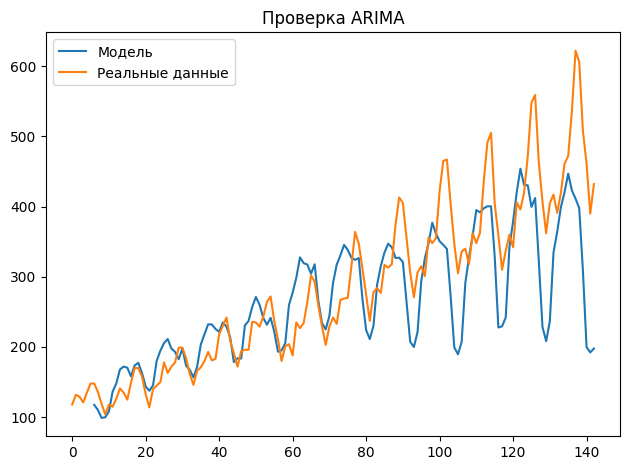

In [518]:
plt.plot(np.arange(arima.p, arima.ar.height +arima.p), arima.build_predict(0), label='Модель') #0 означает что мы предсказываем в рамках известного нам промежутка времени
plt.plot(np.arange(len(diff_y)), df.Passengers[1:], label='Реальные данные') # реальные данные

plt.title('Проверка ARIMA')
plt.legend()
plt.tight_layout()
plt.show()

Стоит уточнить, что это было для проверки работы модели, видно, что модель с данными параметрами плохая, мы сейчас подберем хорошие(ранее выбрали 15, потому возьмем 15)

In [519]:
train_arima = ARIMA(df.Passengers[:len(df.Passengers) - 12], 15, 15) #инициализация новой аримы

0.822778855875661


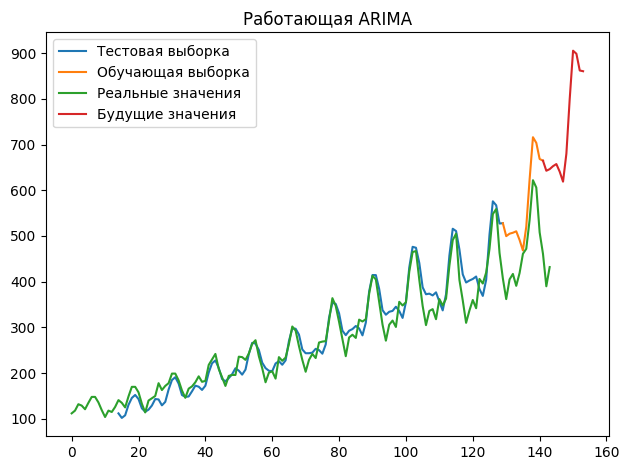

In [520]:
sm_pred = np.array(train_arima.build_predict(24))
x_train = sm_pred[:len(sm_pred) - 24]
x_test = sm_pred[len(sm_pred) - 25:len(sm_pred) - 12]
x_future = sm_pred[len(sm_pred) - 13:]

plt.plot(np.arange(train_arima.p-1, len(x_train)-1 + train_arima.p), np.array(x_train), label='Тестовая выборка')
plt.plot(np.arange(len(x_train) + train_arima.p-2, len(x_train) + train_arima.p + len(x_test)-2), np.array(x_test), label='Обучающая выборка')
plt.plot(df.Passengers[:], label='Реальные значения')
plt.plot(np.arange(len(x_train) + train_arima.p + len(x_test)-3, len(sm_pred) + train_arima.p-1), x_future, label='Будущие значения')
plt.legend(loc='best')
plt.title('Работающая ARIMA')
plt.tight_layout()
plt.show()

Можно сделать вывод, что модель хорошо уловила закономерность как внутри интервала, так и снаружи(тестовая выборка и обучающая соответственно) Прогнозы следующих значений выглядят логично(ну на мой взгляд точно)

In [521]:

y_train = df['Passengers'][train_arima.p + 1:len(df.Passengers) - 12]
y_test = df[
    'Passengers'
][len(df.Passengers) - 13:]
mse = mean_squared_error(x_train, y_train)

mae = mean_absolute_error(x_train, y_train)

r2 = r2_score(x_train, y_train)

print("На обучающей выборке")
print("MSE:", mse)
print("MAE: ", mae)
print("R2: ", r2)

mse = mean_squared_error(x_test, y_test)

mae = mean_absolute_error(x_test, y_test)

r2 = r2_score(x_test, y_test)

print("На тестовой выборке")
print("MSE:", mse)
print("MAE: ", mae)
print("R2: ", r2)



На обучающей выборке
MSE: 3894.7275846619673
MAE:  47.784600636314025
R2:  0.7064928265485517
На тестовой выборке
MSE: 22661.236763655525
MAE:  124.98304351856709
R2:  -1.9978278771691076


Ну можно заметить, что r^2 стал лучше на тестовой выборке, а на обучающей улучшился.
Почему такие отклонения между реальными и прогнозируемыми? Предположительно, что модель недостаточно уловила закономерность, чтобы улучшить точность, можно использовать другие подходы конкретно, можно заменить подход yt = ut + ht, на например yt = ut * ht + c, потому что очевидно, что колебания графика также растут с увеличением тренда, потому логично использовать их в данном случае в произведении, а не в сумме.

Ну и понятно, что не стоит брать много предыдущих значений, а то модель просто подгонит веса под них, а не уловит какую-то закономерность. И получится что-то переобученное, что нам совершенно не нужно.

# Задание 6

Задание должно быть выполнено в формате Jupyter Notebook. Сделано


Код должен быть хорошо структурирован и прокомментирован. Сделано


Графики должны быть четкими и информативными, с соответствующими
подписями и легендами. Сделано


Выводы и обсуждение должны быть представлены в письменной форме и
содержать обоснованные аргументы. Сделано


Срок выполнения задания – одна неделя (6 баллов). Успели